# Table of Content
* [Read-CSV](#Read-CSV)
* [Categorical-variables-handling](#Categorical-variables-handling)
* [Numeric-variables-handing](#Numeric-variables-handing)
* [Pipeline-to-process-all-variables](#Pipeline-to-process-all-variables)
* [Create-features-and-label](#Create-features-and-label)
* [Split-training-set-and-test-set](#Split-training-set-and-test-set)
* [Logistic-Regression-fitting](#Logistic-Regression-fitting)
* [Hyper-parameter-tunning-for-logistic-regression](#Hyper-parameter-tunning-for-logistic-regression)
* [Decision-Tree-fitting](#Decision-Tree-fitting)
* [Random-Forest-fitting](#Random-Forest-fitting)

In [1]:
import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.ml.feature.OneHotEncoderEstimator
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.mllib.feature.Normalizer
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.classification.LogisticRegression
import org.apache.spark.sql._

Intitializing Scala interpreter ...

Spark Web UI available at http://994182a2b062:4040
SparkContext available as 'sc' (version = 2.4.3, master = local[*], app id = local-1559706677931)
SparkSession available as 'spark'


import org.apache.spark.ml.feature.StringIndexer
import org.apache.spark.ml.feature.OneHotEncoderEstimator
import org.apache.spark.ml.{Pipeline, PipelineModel}
import org.apache.spark.ml.feature.StandardScaler
import org.apache.spark.mllib.feature.Normalizer
import org.apache.spark.ml.feature.VectorAssembler
import org.apache.spark.ml.classification.LogisticRegression
import org.apache.spark.sql._


# Read CSV

Also invert the label
* 1: bad loan
* 0: good loan

In [2]:
val invertLabel = udf((v: Int) => v match {
    case 0 => 1
    case 1 => 0
})

invertLabel: org.apache.spark.sql.expressions.UserDefinedFunction = UserDefinedFunction(<function1>,IntegerType,Some(List(IntegerType)))


In [3]:
val df = spark.read.format("csv")
  .option("inferSchema", "true")
  .option("header", "true")
  .load("LCLoan_Wrangled.csv")
  .withColumn("loan_status",invertLabel($"loan_status"))

df: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 63 more fields]


# Categorical variables handling

In [4]:
val categoricalColumns = df.dtypes.filter(column => column._2 == "StringType").map(_._1)

categoricalColumns: Array[String] = Array(term, grade, sub_grade, emp_title, emp_length, home_ownership, verification_status, issue_d, purpose, title, zip_code, addr_state, earliest_cr_line, initial_list_status, last_pymnt_d, last_credit_pull_d, application_type)


In [5]:
val categoricalFeatures = categoricalColumns.flatMap{ name =>
    
    val stringIndexer = new StringIndexer()
      .setInputCol(name)
      .setOutputCol(name + "_index")
      .setHandleInvalid("keep")
    
    val oneHotEncoder = new OneHotEncoderEstimator()
      .setInputCols(Array(name + "_index"))
      .setOutputCols(Array(name + "_vec"))
      .setDropLast(false)
    
    Array(stringIndexer, oneHotEncoder)
}

categoricalFeatures: Array[org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Model[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature.StringIndexerModel <: org.apache.spark.ml.Transformer with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.MLWritable] with org.apache.spark.ml.param.shared.HasHandleInvalid with org.apache.spark.ml.util.DefaultParamsWritable{def copy(extra: org.apache.spark.ml.param.ParamMap): org.apache.spark.ml.Estimator[_ >: org.apache.spark.ml.feature.OneHotEncoderModel with org.apache.spark.ml.feature...


# Numeric variables handing

In [12]:
val numericColumns = df.dtypes.filter(column => column._2 == "IntegerType" || column._2 == "DoubleType").map(_._1)
                    .filterNot( c => c == "loan_status" )

numericColumns: Array[String] = Array(loan_amnt, int_rate, annual_inc, dti, delinq_2yrs, inq_last_6mths, open_acc, pub_rec, revol_bal, revol_util, total_acc, out_prncp, total_pymnt, total_rec_int, total_rec_late_fee, collection_recovery_fee, last_pymnt_amnt, collections_12_mths_ex_med, policy_code, acc_now_delinq, tot_coll_amt, tot_cur_bal, total_rev_hi_lim, acc_open_past_24mths, chargeoff_within_12_mths, delinq_amnt, mo_sin_old_il_acct, mo_sin_old_rev_tl_op, mo_sin_rcnt_rev_tl_op, mo_sin_rcnt_tl, mort_acc, mths_since_recent_bc, num_accts_ever_120_pd, num_actv_rev_tl, num_bc_sats, num_il_tl, num_rev_accts, num_sats, num_tl_120dpd_2m, num_tl_90g_dpd_24m, num_tl_op_past_12m, pct_tl_nvr_dlq, percent_bc_gt_75, pub_rec_bankruptcies, tax_liens, tot_hi_cred_lim, total_il_high_credit_limit)


In [13]:
val numericColumnsAssembler = new VectorAssembler()
  .setInputCols(numericColumns)
  .setOutputCol("numerical_features")

numericColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_d37f19c654da


In [14]:
val numericColumnsScaler = new StandardScaler()
      .setInputCol("numerical_features")
      .setOutputCol("numerical_features" + "_vec")
      .setWithStd(true)
      .setWithMean(true)

numericColumnsScaler: org.apache.spark.ml.feature.StandardScaler = stdScal_8f9332e793a1


# Pipeline to process all variables

In [15]:
val pipeline = new Pipeline()
  .setStages(categoricalFeatures ++ Array(numericColumnsAssembler,numericColumnsScaler) )

val df_transformed = pipeline
  .fit(df)
  .transform(df)

pipeline: org.apache.spark.ml.Pipeline = pipeline_9517c01dfefa
df_transformed: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 99 more fields]


# Create features and label

In [16]:
val featureColumns = df_transformed.columns.filter(_.contains("_vec"))

featureColumns: Array[String] = Array(term_vec, grade_vec, sub_grade_vec, emp_title_vec, emp_length_vec, home_ownership_vec, verification_status_vec, issue_d_vec, purpose_vec, title_vec, zip_code_vec, addr_state_vec, earliest_cr_line_vec, initial_list_status_vec, last_pymnt_d_vec, last_credit_pull_d_vec, application_type_vec, numerical_features_vec)


In [17]:
val featureColumnsAssembler = new VectorAssembler()
  .setInputCols(featureColumns)
  .setOutputCol("features")

val df_input = featureColumnsAssembler.transform(df_transformed).withColumn("label",col("loan_status"))

2019-06-05 03:54:10,601 WARN  [Thread-4] util.Utils (Logging.scala:logWarning(66)) - Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.debug.maxToStringFields' in SparkEnv.conf.


featureColumnsAssembler: org.apache.spark.ml.feature.VectorAssembler = vecAssembler_84cec32346f7
df_input: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 101 more fields]


# Split training set and test set

In [20]:
val Array(trainingData, testData) = df_input.randomSplit(Array(0.8, 0.2), seed = 1234L)

trainingData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 101 more fields]
testData: org.apache.spark.sql.Dataset[org.apache.spark.sql.Row] = [loan_amnt: int, term: string ... 101 more fields]


In [21]:
testData.count

res1: Long = 3967


In [22]:
trainingData.count

res2: Long = 16103


# Logistic Regression fitting

In [23]:
val lr = new LogisticRegression()
//   .setMaxIter(100)
//   .setRegParam(0.3)
//   .setElasticNetParam(0.8)

lr: org.apache.spark.ml.classification.LogisticRegression = logreg_b535cc854108


In [24]:
// Fit the model
val lrModel = lr.fit(trainingData)

2019-06-05 03:55:07,726 WARN  [Thread-4] netlib.BLAS (BLAS.java:<clinit>(61)) - Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
2019-06-05 03:55:07,726 WARN  [Thread-4] netlib.BLAS (BLAS.java:<clinit>(61)) - Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


lrModel: org.apache.spark.ml.classification.LogisticRegressionModel = LogisticRegressionModel: uid = logreg_b535cc854108, numClasses = 2, numFeatures = 10856


## Training Summary

In [25]:
// Extract the summary from the returned LogisticRegressionModel instance trained in the earlier
// example
val trainingSummary = lrModel.binarySummary
val accuracy = trainingSummary.accuracy
val falsePositiveRate = trainingSummary.weightedFalsePositiveRate
val truePositiveRate = trainingSummary.weightedTruePositiveRate
val fMeasure = trainingSummary.weightedFMeasure
val precision = trainingSummary.weightedPrecision
val recall = trainingSummary.weightedRecall
println(s"Accuracy: $accuracy\nFPR: $falsePositiveRate\nTPR: $truePositiveRate\n" +
  s"F-measure: $fMeasure\nPrecision: $precision\nRecall: $recall")

Accuracy: 1.0
FPR: 0.0
TPR: 1.0
F-measure: 1.0
Precision: 1.0
Recall: 1.0


trainingSummary: org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummary = org.apache.spark.ml.classification.BinaryLogisticRegressionTrainingSummaryImpl@1119d9d6
accuracy: Double = 1.0
falsePositiveRate: Double = 0.0
truePositiveRate: Double = 1.0
fMeasure: Double = 1.0
precision: Double = 1.0
recall: Double = 1.0


In [26]:
val roc = trainingSummary.roc
roc.show()
println(s"areaUnderROC: ${trainingSummary.areaUnderROC}")

+--------------------+------------------+
|                 FPR|               TPR|
+--------------------+------------------+
|                 0.0|               0.0|
|                 0.0|0.9270205066344994|
|0.001799930771893...|               1.0|
|0.011976462443752164|               1.0|
| 0.02215299411561094|               1.0|
| 0.03232952578746971|               1.0|
|0.042506057459328485|               1.0|
|0.052682589131187264|               1.0|
| 0.06285912080304604|               1.0|
| 0.07303565247490482|               1.0|
| 0.08321218414676358|               1.0|
| 0.09338871581862236|               1.0|
| 0.10356524749048114|               1.0|
|  0.1137417791623399|               1.0|
| 0.12391831083419869|               1.0|
| 0.13409484250605747|               1.0|
| 0.14427137417791625|               1.0|
|   0.154447905849775|               1.0|
| 0.16462443752163378|               1.0|
| 0.17480096919349256|               1.0|
+--------------------+------------

roc: org.apache.spark.sql.DataFrame = [FPR: double, TPR: double]


In [27]:
roc.createOrReplaceTempView("roc")

In [28]:
! pip install pandas
! pip install matplotlib

     |################################| 10.1MB 30.4MB/s eta 0:00:01
     |############################    | 15.4MB 51.0MB/s eta 0:00:01

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |################################| 13.1MB 15.7MB/s eta 0:00:01
     |################################| 92kB 26.4MB/s eta 0:00:01
     |################################| 71kB 24.8MB/s eta 0:00:01


        FPR       TPR
0  0.000000  0.000000
1  0.000000  0.927021
2  0.001800  1.000000
3  0.011976  1.000000
4  0.022153  1.000000


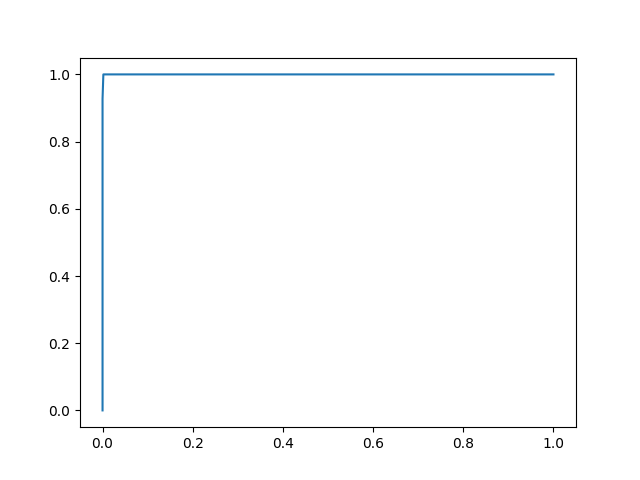

In [29]:
%%python
import pandas as pd
import matplotlib.pyplot as plt
import tempfile
from IPython.display import Image

roc = spark.sql("select * from roc")
rocPandas = roc.toPandas()
print(rocPandas.head())
plt.clf()
plt.plot(rocPandas['FPR'],rocPandas['TPR'])
with tempfile.NamedTemporaryFile(suffix=".png") as fo:
    plt.savefig(fo.name)
    retval = Image(filename=fo.name)

## Prediction on test set

In [30]:
val prediction = lrModel.transform(testData)

prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


## Evaluation

In [31]:
def evaluatePrediction(prediction: DataFrame) = {
    prediction.createOrReplaceTempView("prediction")
    
    spark.sql("""
select label,prediction,count(1) from prediction group by label,prediction
""").show(false)
    
    spark.sql("""
select 
(TP+TN)/(P+N) as Accuracy,
TP/(TP+FP) as Precision,
TP/(TP+FN) as Recall,
2*TP/(2*TP+FP+FN) as F1
from (
    select 
    count(1) as total, 
    sum(case when label = 1 and prediction = 1 then 1 else 0 end) as TP,
    sum(case when label = 0 and prediction = 0 then 1 else 0 end) as TN,
    sum(case when label = 0 and prediction = 1 then 1 else 0 end) as FP,
    sum(case when label = 1 and prediction = 0 then 1 else 0 end) as FN,
    sum(case when label = 1 then 1 else 0 end) as P,
    sum(case when label = 0 then 1 else 0 end) as N
    from prediction
    )
""").show(false)
}

evaluatePrediction: (prediction: org.apache.spark.sql.DataFrame)Unit


In [32]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |128     |
|0    |0.0       |3423    |
|1    |1.0       |300     |
|0    |1.0       |116     |
+-----+----------+--------+

+------------------+------------------+------------------+------------------+
|Accuracy          |Precision         |Recall            |F1                |
+------------------+------------------+------------------+------------------+
|0.9384925636501135|0.7211538461538461|0.7009345794392523|0.7109004739336493|
+------------------+------------------+------------------+------------------+



# Decision Tree fitting

In [33]:
import org.apache.spark.ml.classification.DecisionTreeClassificationModel
import org.apache.spark.ml.classification.DecisionTreeClassifier
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator

val dt = new DecisionTreeClassifier()
  .setLabelCol("label")
  .setFeaturesCol("features")

import org.apache.spark.ml.classification.DecisionTreeClassificationModel
import org.apache.spark.ml.classification.DecisionTreeClassifier
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator
dt: org.apache.spark.ml.classification.DecisionTreeClassifier = dtc_b7967bbf6db0


In [34]:
val model = dt.fit(trainingData)
val prediction = model.transform(testData)

2019-06-05 03:56:29,337 WARN  [Executor task launch worker for task 418] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_495_1 in memory! (computed 140.4 MB so far)
2019-06-05 03:56:29,341 WARN  [Executor task launch worker for task 418] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_495_1 to disk instead.
2019-06-05 03:56:30,778 WARN  [Executor task launch worker for task 417] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_495_0 in memory! (computed 210.9 MB so far)
2019-06-05 03:56:30,778 WARN  [Executor task launch worker for task 417] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_495_0 to disk instead.
2019-06-05 03:56:31,771 WARN  [Executor task launch worker for task 418] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_495_1 in memory! (computed 210.9 MB so far)
2019-06-05 03:56:34,408 WARN  [Executor task launch worker fo

model: org.apache.spark.ml.classification.DecisionTreeClassificationModel = DecisionTreeClassificationModel (uid=dtc_b7967bbf6db0) of depth 5 with 27 nodes
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


In [35]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |59      |
|0    |0.0       |3477    |
|1    |1.0       |369     |
|0    |1.0       |62      |
+-----+----------+--------+

+------------------+------------------+------------------+------------------+
|Accuracy          |Precision         |Recall            |F1                |
+------------------+------------------+------------------+------------------+
|0.9694983614822283|0.8561484918793504|0.8621495327102804|0.8591385331781141|
+------------------+------------------+------------------+------------------+



# Random Forest fitting

In [36]:
import org.apache.spark.ml.classification.{RandomForestClassificationModel, RandomForestClassifier}
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator

import org.apache.spark.ml.classification.{RandomForestClassificationModel, RandomForestClassifier}
import org.apache.spark.ml.evaluation.MulticlassClassificationEvaluator


In [40]:
val rf = new RandomForestClassifier()
  .setLabelCol("label")
  .setFeaturesCol("features")
//   .setNumTrees(100)

rf: org.apache.spark.ml.classification.RandomForestClassifier = rfc_bd8a1872fcaf


In [41]:
val model = rf.fit(trainingData)
val prediction = model.transform(testData)

2019-06-05 03:58:18,561 WARN  [Executor task launch worker for task 889] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_761_1 in memory! (computed 140.9 MB so far)
2019-06-05 03:58:18,562 WARN  [Executor task launch worker for task 889] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_761_1 to disk instead.
2019-06-05 03:58:20,649 WARN  [Executor task launch worker for task 888] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_761_0 in memory! (computed 211.6 MB so far)
2019-06-05 03:58:20,649 WARN  [Executor task launch worker for task 888] storage.BlockManager (Logging.scala:logWarning(66)) - Persisting block rdd_761_0 to disk instead.
2019-06-05 03:58:21,329 WARN  [Executor task launch worker for task 889] memory.MemoryStore (Logging.scala:logWarning(66)) - Not enough space to cache rdd_761_1 in memory! (computed 211.6 MB so far)
2019-06-05 03:58:24,105 WARN  [Executor task launch worker fo

model: org.apache.spark.ml.classification.RandomForestClassificationModel = RandomForestClassificationModel (uid=rfc_bd8a1872fcaf) with 20 trees
prediction: org.apache.spark.sql.DataFrame = [loan_amnt: int, term: string ... 104 more fields]


In [42]:
evaluatePrediction(prediction)

+-----+----------+--------+
|label|prediction|count(1)|
+-----+----------+--------+
|1    |0.0       |428     |
|0    |0.0       |3539    |
+-----+----------+--------+

+------------------+---------+------+---+
|Accuracy          |Precision|Recall|F1 |
+------------------+---------+------+---+
|0.8921099067305268|null     |0.0   |0.0|
+------------------+---------+------+---+

